mostly from [this PyTorch tutorial](https://pytorch.org/tutorials/beginner/transformer_tutorial.html)

In [1]:
%matplotlib inline


Sequence-to-Sequence Modeling with nn.Transformer and TorchText
===============================================================

This is a tutorial on how to train a sequence-to-sequence model
that uses the
`nn.Transformer <https://pytorch.org/docs/master/nn.html?highlight=nn%20transformer#torch.nn.Transformer>`__ module.

PyTorch 1.2 release includes a standard transformer module based on the
paper `Attention is All You
Need <https://arxiv.org/pdf/1706.03762.pdf>`__. The transformer model
has been proved to be superior in quality for many sequence-to-sequence
problems while being more parallelizable. The ``nn.Transformer`` module
relies entirely on an attention mechanism (another module recently
implemented as `nn.MultiheadAttention <https://pytorch.org/docs/master/nn.html?highlight=multiheadattention#torch.nn.MultiheadAttention>`__) to draw global dependencies
between input and output. The ``nn.Transformer`` module is now highly
modularized such that a single component (like `nn.TransformerEncoder <https://pytorch.org/docs/master/nn.html?highlight=nn%20transformerencoder#torch.nn.TransformerEncoder>`__
in this tutorial) can be easily adapted/composed.

![](../_static/img/transformer_architecture.jpg)





Define the model
----------------




In this tutorial, we train ``nn.TransformerEncoder`` model on a
language modeling task. The language modeling task is to assign a
probability for the likelihood of a given word (or a sequence of words)
to follow a sequence of words. A sequence of tokens are passed to the embedding
layer first, followed by a positional encoding layer to account for the order
of the word (see the next paragraph for more details). The
``nn.TransformerEncoder`` consists of multiple layers of
`nn.TransformerEncoderLayer <https://pytorch.org/docs/master/nn.html?highlight=transformerencoderlayer#torch.nn.TransformerEncoderLayer>`__. Along with the input sequence, a square
attention mask is required because the self-attention layers in
``nn.TransformerEncoder`` are only allowed to attend the earlier positions in
the sequence. For the language modeling task, any tokens on the future
positions should be masked. To have the actual words, the output
of ``nn.TransformerEncoder`` model is sent to the final Linear
layer, which is followed by a log-Softmax function.




In [2]:
import math
import torch
import torch.nn as nn
import torch.nn.functional as F

class TransformerModel(nn.Module):

    def __init__(self, ntoken, ninp, nhead, nhid, nlayers, dropout=0.5):
        super(TransformerModel, self).__init__()
        from torch.nn import TransformerEncoder, TransformerEncoderLayer
        self.model_type = 'Transformer'
        self.src_mask = None
        self.pos_encoder = PositionalEncoding(ninp, dropout)
        encoder_layers = TransformerEncoderLayer(ninp, nhead, nhid, dropout)
        self.transformer_encoder = TransformerEncoder(encoder_layers, nlayers)
        self.encoder = nn.Embedding(ntoken, ninp)
        self.ninp = ninp
        self.decoder = nn.Linear(ninp, ntoken)

        self.init_weights()

    def _generate_square_subsequent_mask(self, sz):
        mask = (torch.triu(torch.ones(sz, sz)) == 1).transpose(0, 1)
        mask = mask.float().masked_fill(mask == 0, float('-inf')).masked_fill(mask == 1, float(0.0))
        return mask

    def init_weights(self):
        initrange = 0.1
        self.encoder.weight.data.uniform_(-initrange, initrange)
        self.decoder.bias.data.zero_()
        self.decoder.weight.data.uniform_(-initrange, initrange)

    def forward(self, src):
        if self.src_mask is None or self.src_mask.size(0) != len(src):
            device = src.device
            mask = self._generate_square_subsequent_mask(len(src)).to(device)
            self.src_mask = mask

        src = self.encoder(src) * math.sqrt(self.ninp)
        src = self.pos_encoder(src)
        output = self.transformer_encoder(src, self.src_mask)
        output = self.decoder(output)
        return output

``PositionalEncoding`` module injects some information about the
relative or absolute position of the tokens in the sequence. The
positional encodings have the same dimension as the embeddings so that
the two can be summed. Here, we use ``sine`` and ``cosine`` functions of
different frequencies.




In [3]:
class PositionalEncoding(nn.Module):

    def __init__(self, d_model, dropout=0.1, max_len=5000):
        super(PositionalEncoding, self).__init__()
        self.dropout = nn.Dropout(p=dropout)

        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2).float() * (-math.log(10000.0) / d_model))
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        pe = pe.unsqueeze(0).transpose(0, 1)
        self.register_buffer('pe', pe)

    def forward(self, x):
        x = x + self.pe[:x.size(0), :]
        return self.dropout(x)

torch.Size([20, 1, 20])


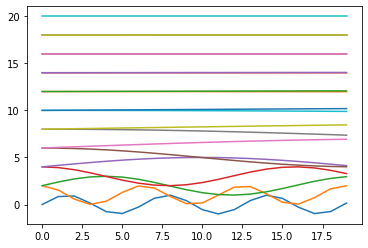

In [39]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

pe = PositionalEncoding(20, 0)
y = pe.forward(torch.arange(20.))
print(y.shape)
plt.plot(y.squeeze());


Load and batch data
-------------------




The training process uses Wikitext-2 dataset from ``torchtext``. The
vocab object is built based on the train dataset and is used to numericalize
tokens into tensors. Starting from sequential data, the ``batchify()``
function arranges the dataset into columns, trimming off any tokens remaining
after the data has been divided into batches of size ``batch_size``.
For instance, with the alphabet as the sequence (total length of 26)
and a batch size of 4, we would divide the alphabet into 4 sequences of
length 6:

\begin{align}\begin{bmatrix}
  \text{A} & \text{B} & \text{C} & \ldots & \text{X} & \text{Y} & \text{Z}
  \end{bmatrix}
  \Rightarrow
  \begin{bmatrix}
  \begin{bmatrix}\text{A} \\ \text{B} \\ \text{C} \\ \text{D} \\ \text{E} \\ \text{F}\end{bmatrix} &
  \begin{bmatrix}\text{G} \\ \text{H} \\ \text{I} \\ \text{J} \\ \text{K} \\ \text{L}\end{bmatrix} &
  \begin{bmatrix}\text{M} \\ \text{N} \\ \text{O} \\ \text{P} \\ \text{Q} \\ \text{R}\end{bmatrix} &
  \begin{bmatrix}\text{S} \\ \text{T} \\ \text{U} \\ \text{V} \\ \text{W} \\ \text{X}\end{bmatrix}
  \end{bmatrix}\end{align}

These columns are treated as independent by the model, which means that
the dependence of ``G`` and ``F`` can not be learned, but allows more
efficient batch processing.




In [5]:
import torchtext
from torchtext.data.utils import get_tokenizer
TEXT = torchtext.data.Field(tokenize=get_tokenizer("basic_english"),
                            init_token='<sos>',
                            eos_token='<eos>',
                            lower=True)
train_txt, val_txt, test_txt = torchtext.datasets.WikiText2.splits(TEXT)
TEXT.build_vocab(train_txt)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

def batchify(data, bsz):
    data = TEXT.numericalize([data.examples[0].text])
    # Divide the dataset into bsz parts.
    nbatch = data.size(0) // bsz
    # Trim off any extra elements that wouldn't cleanly fit (remainders).
    data = data.narrow(0, 0, nbatch * bsz)
    # Evenly divide the data across the bsz batches.
    data = data.view(bsz, -1).t().contiguous()
    return data.to(device)

batch_size = 20
eval_batch_size = 10
train_data = batchify(train_txt, batch_size)
val_data = batchify(val_txt, eval_batch_size)
test_data = batchify(test_txt, eval_batch_size)

downloading wikitext-2-v1.zip


wikitext-2-v1.zip: 100%|██████████| 4.48M/4.48M [01:09<00:00, 64.3kB/s]


extracting


In [18]:
TEXT

Functions to generate input and target sequence
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~




``get_batch()`` function generates the input and target sequence for
the transformer model. It subdivides the source data into chunks of
length ``bptt``. For the language modeling task, the model needs the
following words as ``Target``. For example, with a ``bptt`` value of 2,
we’d get the following two Variables for ``i`` = 0:

![](../_static/img/transformer_input_target.png)


It should be noted that the chunks are along dimension 0, consistent
with the ``S`` dimension in the Transformer model. The batch dimension
``N`` is along dimension 1.




In [6]:
bptt = 35
def get_batch(source, i):
    seq_len = min(bptt, len(source) - 1 - i)
    data = source[i:i+seq_len]
    target = source[i+1:i+1+seq_len].view(-1)
    return data, target

Initiate an instance
--------------------




The model is set up with the hyperparameter below. The vocab size is
equal to the length of the vocab object.




In [7]:
ntokens = len(TEXT.vocab.stoi) # the size of vocabulary
emsize = 200 # embedding dimension
nhid = 200 # the dimension of the feedforward network model in nn.TransformerEncoder
nlayers = 2 # the number of nn.TransformerEncoderLayer in nn.TransformerEncoder
nhead = 2 # the number of heads in the multiheadattention models
dropout = 0.2 # the dropout value
model = TransformerModel(ntokens, emsize, nhead, nhid, nlayers, dropout).to(device)

Run the model
-------------




`CrossEntropyLoss <https://pytorch.org/docs/master/nn.html?highlight=crossentropyloss#torch.nn.CrossEntropyLoss>`__
is applied to track the loss and
`SGD <https://pytorch.org/docs/master/optim.html?highlight=sgd#torch.optim.SGD>`__
implements stochastic gradient descent method as the optimizer. The initial
learning rate is set to 5.0. `StepLR <https://pytorch.org/docs/master/optim.html?highlight=steplr#torch.optim.lr_scheduler.StepLR>`__ is
applied to adjust the learn rate through epochs. During the
training, we use
`nn.utils.clip_grad_norm\_ <https://pytorch.org/docs/master/nn.html?highlight=nn%20utils%20clip_grad_norm#torch.nn.utils.clip_grad_norm_>`__
function to scale all the gradient together to prevent exploding.




In [24]:
TEXT.vocab.stoi

defaultdict(<bound method Vocab._default_unk_index of <torchtext.vocab.Vocab object at 0x7fbe9f221fd0>>,
            {'<unk>': 0,
             '<pad>': 1,
             '<sos>': 2,
             '<eos>': 3,
             'the': 4,
             ',': 5,
             '.': 6,
             'of': 7,
             'and': 8,
             'in': 9,
             'to': 10,
             'a': 11,
             '=': 12,
             'was': 13,
             "'": 14,
             '@-@': 15,
             'on': 16,
             'as': 17,
             's': 18,
             'that': 19,
             'for': 20,
             'with': 21,
             'by': 22,
             ')': 23,
             '(': 24,
             '@': 25,
             'is': 26,
             'it': 27,
             'from': 28,
             'at': 29,
             'his': 30,
             'he': 31,
             'were': 32,
             'an': 33,
             'had': 34,
             'which': 35,
             'be': 36,
             'are': 37,
         

In [23]:
TEXT.vocab.freqs

Counter({'<eos>': 36718,
         '=': 29570,
         'valkyria': 54,
         'chronicles': 53,
         'iii': 231,
         'senjō': 5,
         'no': 1702,
         '3': 1601,
         '<unk>': 54625,
         '(': 11992,
         'japanese': 255,
         '戦場のヴァルキュリア3': 3,
         ',': 102615,
         'lit': 29,
         '.': 83397,
         'of': 57030,
         'the': 130768,
         'battlefield': 38,
         ')': 12004,
         'commonly': 119,
         'referred': 206,
         'to': 39521,
         'as': 15058,
         'outside': 309,
         'japan': 212,
         'is': 11691,
         'a': 36523,
         'tactical': 32,
         'role': 598,
         '@-@': 16906,
         'playing': 342,
         'video': 725,
         'game': 2077,
         'developed': 429,
         'by': 12718,
         'sega': 9,
         'and': 50735,
         'media': 262,
         'vision': 87,
         'for': 13794,
         'playstation': 124,
         'portable': 33,
         'released'

In [11]:
criterion = nn.CrossEntropyLoss()
lr = 5 # learning rate
optimizer = torch.optim.SGD(model.parameters(), lr=lr)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, 1.0, gamma=0.95)

import time
def train():
    model.train() # Turn on the train mode
    total_loss = 0.
    start_time = time.time()
    ntokens = len(TEXT.vocab.stoi)
    for batch, i in enumerate(range(0, train_data.size(0) - 1, bptt)):
        data, targets = get_batch(train_data, i)
        optimizer.zero_grad()
        output = model(data)
        loss = criterion(output.view(-1, ntokens), targets)
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 0.5)
        optimizer.step()

        total_loss += loss.item()
        log_interval = 200
        if batch % log_interval == 0 and batch > 0:
            cur_loss = total_loss / log_interval
            elapsed = time.time() - start_time
            print('| epoch {:3d} | {:5d}/{:5d} batches | '
                  'lr {:02.2f} | ms/batch {:5.2f} | '
                  'loss {:5.2f} | ppl {:8.2f}'.format(
                    epoch, batch, len(train_data) // bptt, scheduler.get_lr()[0],
                    elapsed * 1000 / log_interval,
                    cur_loss, math.exp(cur_loss)))
            total_loss = 0
            start_time = time.time()

def evaluate(eval_model, data_source):
    eval_model.eval() # Turn on the evaluation mode
    total_loss = 0.
    ntokens = len(TEXT.vocab.stoi)
    with torch.no_grad():
        for i in range(0, data_source.size(0) - 1, bptt):
            data, targets = get_batch(data_source, i)
            output = eval_model(data)
            output_flat = output.view(-1, ntokens)
            total_loss += len(data) * criterion(output_flat, targets).item()
    return total_loss / (len(data_source) - 1)

Loop over epochs. Save the model if the validation loss is the best
we've seen so far. Adjust the learning rate after each epoch.



In [12]:
best_val_loss = float("inf")
epochs = 3 # The number of epochs
best_model = None

for epoch in range(1, epochs + 1):
    epoch_start_time = time.time()
    train()
    val_loss = evaluate(model, val_data)
    print('-' * 89)
    print('| end of epoch {:3d} | time: {:5.2f}s | valid loss {:5.2f} | '
          'valid ppl {:8.2f}'.format(epoch, (time.time() - epoch_start_time),
                                     val_loss, math.exp(val_loss)))
    print('-' * 89)

    if val_loss < best_val_loss:
        best_val_loss = val_loss
        best_model = model

    scheduler.step()

| epoch   1 |   200/ 2981 batches | lr 0.01 | ms/batch 648.79 | loss  6.38 | ppl   588.99
| epoch   1 |   400/ 2981 batches | lr 0.01 | ms/batch 498.79 | loss  6.62 | ppl   751.31
| epoch   1 |   600/ 2981 batches | lr 0.01 | ms/batch 566.16 | loss  6.72 | ppl   825.56


KeyboardInterrupt: 

Evaluate the model with the test dataset
-------------------------------------

Apply the best model to check the result with the test dataset.



In [9]:
test_loss = evaluate(best_model, test_data)
print('=' * 89)
print('| End of training | test loss {:5.2f} | test ppl {:8.2f}'.format(
    test_loss, math.exp(test_loss)))
print('=' * 89)

| End of training | test loss  5.43 | test ppl   229.19
